# **Object-Detection-From-Drone-For-Surveillance - Mask RCNN**

Install the pycocotools package and clone the vision repository from the official PyTorch GitHub account. 

The checkout command with the v0.10.0 parameter is used to obtain the specified version of the PyTorch vision library. This package provides a collection of datasets, models, and transforms for various computer vision tasks such as object detection, semantic segmentation, and image classification. 

The pycocotools library is used for loading and working with the COCO (Common Objects in Context) dataset, which is a widely used benchmark for object detection and segmentation tasks in computer vision.

In [1]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.10.0

Cloning into 'vision'...
remote: Enumerating objects: 323011, done.
remote: Counting objects: 100% (982/982), done.
remote: Compressing objects: 100% (217/217), done.
remote: Total 323011 (delta 772), reused 955 (delta 756), pack-reused 322029
Receiving objects: 100% (323011/323011), 657.02 MiB | 32.06 MiB/s, done.
Resolving deltas: 100% (296811/296811), done.
fatal: not a git repository (or any of the parent directories): .git


In [31]:
!unzip VisDrone2019-DET-val.zip
!unzip VisDrone2019-DET-test-dev.zip

Archive:  VisDrone2019-DET-val.zip
replace VisDrone2019-DET-val/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  VisDrone2019-DET-test-dev.zip
   creating: annotations/
  inflating: annotations/0000006_00159_d_0000001.txt  
  inflating: annotations/0000006_00611_d_0000002.txt  
  inflating: annotations/0000006_01111_d_0000003.txt  
  inflating: annotations/0000006_01275_d_0000004.txt  
  inflating: annotations/0000006_01659_d_0000004.txt  
  inflating: annotations/0000006_02138_d_0000006.txt  
  inflating: annotations/0000006_02616_d_0000007.txt  
  inflating: annotations/0000006_03636_d_0000009.txt  
  inflating: annotations/0000006_04050_d_0000010.txt  
  inflating: annotations/0000006_04309_d_0000011.txt  
  inflating: annotations/0000006_05168_d_0000013.txt  
  inflating: annotations/0000006_05208_d_0000014.txt  
  inflating: annotations/0000006_05575_d_0000016.txt  
  inflating: annotations/0000006_05999_d_0000017.txt  
  inflating: annotations/0000006_06773_d_0000018.tx

In [3]:
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

### **Imports :** 

This code cell imports various Python libraries for image processing and machine learning tasks. It starts with importing basic libraries such as numpy, pandas, and OpenCV. Then, it imports various libraries from the PyTorch ecosystem such as Torchvision, which is a PyTorch library for computer vision tasks, and torchvision's detection module, which includes various object detection models such as Mask R-CNN.

The code also imports a few helper libraries such as engine, utils, and transforms for training and evaluating object detection models. Additionally, it imports the KFold library for cross-validation and DataLoader and SubsetRandomSampler for data loading and shuffling.

Finally, the code sets a few flags for torch backend to disallow tf32 matrix multiplication and prints the PyTorch and Torchvision versions.

In [65]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

import sys
sys.path.append('/content/')

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor  

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, SubsetRandomSampler

torch.backends.cuda.matmul.allow_tf32 = False

print(torch.__version__)
print(torchvision.__version__)

2.0.0+cu118
0.15.1+cu118


In [66]:
files_dir_train = '/content/VisDrone2019-DET-val/'
files_dir_test = '/content/VisDrone2019-DET-test-dev/'

## **Visdrone Dataset Class**

This code defines a PyTorch dataset class for the VisDrone dataset. It reads images and annotations from given directories and returns preprocessed images and their corresponding targets, which include bounding box coordinates, class labels, area, and image ID. It also applies optional transforms to the images and targets.

In [67]:
class VisDroneDataset(torch.utils.data.Dataset):

    def __init__(self, img_dir,ann_dir, width, height, transforms=None):
        self.transforms = transforms
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(img_dir))
                        if image[-4:]=='.jpg']
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'pedestrian','people','bicycle', 
                        'car','van','truck','tricycle','awning-tricycle','bus','motor']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.img_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # dividing by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.txt'
        annot_file_path = os.path.join(self.ann_dir, annot_filename)
        
        boxes = []
        labels = []
        
        
        with open(annot_file_path, 'r') as f:
            for line in f:
                box = [float(x) for x in line.strip().split(',')]
                labels.append(int(box[5]))
                
                xmin, ymin, w, h = box[:4]
                xmax = xmin + w
                ymax = ymin + h
                
                xmin_corr = (xmin/img.shape[1])*self.width
                xmax_corr = (xmax/img.shape[1])*self.width
                ymin_corr = (ymin/img.shape[0])*self.height
                ymax_corr = (ymax/img.shape[0])*self.height
                
                boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)


        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        target["masks"] = torch.zeros((boxes.shape[0], self.height, self.width), dtype=torch.uint8)
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id


        if self.transforms:
            
            sample = self.transforms(image=img_res, bboxes=target['boxes'], labels=labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
            
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)

## **Check Visdrone Dataset**

This code creates two instances of the VisDroneDataset class, one for the training set and one for the testing set, and prints out the length of each dataset. The VisDroneDataset class is a PyTorch dataset class that reads in image and annotation data from a directory, resizes the images to a given width and height, and returns a dictionary with the preprocessed image and annotation data.

In [68]:
# check dataset
dataset_train = VisDroneDataset(files_dir_train+'/images',files_dir_train+'/annotations', 1224, 724)
dataset_test= VisDroneDataset('/content/images','/content/annotations', 1224, 724)
print('length of training dataset = ', len(dataset_train), '\n')
print('length of testing dataset = ', len(dataset_test), '\n')

length of training dataset =  548 

length of testing dataset =  1610 



In [69]:
# getting the image and target for a test index
img1, target = dataset_train[1]
img, target = dataset_test[0]
print(img.shape, '\n',target)

(724, 1224, 3) 
 {'boxes': tensor([[6.1650e+02, 4.3819e+02, 7.1550e+02, 4.9970e+02],
        [5.2020e+02, 3.1042e+02, 5.5260e+02, 3.4638e+02],
        [5.5530e+02, 3.0947e+02, 5.8950e+02, 3.5112e+02],
        [5.9310e+02, 3.3124e+02, 6.7410e+02, 3.6910e+02],
        [6.8490e+02, 3.2746e+02, 7.2090e+02, 3.6910e+02],
        [7.2450e+02, 3.3124e+02, 7.5870e+02, 3.7004e+02],
        [7.6410e+02, 3.2746e+02, 8.0460e+02, 3.7194e+02],
        [8.0550e+02, 3.3030e+02, 8.4420e+02, 3.7194e+02],
        [7.9740e+02, 2.8108e+02, 8.3340e+02, 3.2178e+02],
        [7.2900e+02, 2.8865e+02, 7.9200e+02, 3.2651e+02],
        [7.2450e+02, 2.4228e+02, 7.6590e+02, 2.6878e+02],
        [7.0470e+02, 2.2146e+02, 7.6770e+02, 2.4701e+02],
        [3.9150e+02, 5.0633e+02, 5.1210e+02, 5.6027e+02],
        [4.3920e+02, 4.7983e+02, 5.4540e+02, 5.2904e+02],
        [4.4550e+02, 4.4765e+02, 5.5350e+02, 4.9118e+02],
        [4.5630e+02, 4.2304e+02, 5.5260e+02, 4.5901e+02],
        [4.2570e+02, 3.9938e+02, 5.1930e+02, 

## **Visualizing Bounding Boxes**

The plot_img_bbox function takes an image and its associated target as inputs and displays the image with bounding boxes drawn around the objects in the image. The target should be a dictionary containing the following keys: boxes (bounding boxes), labels (labels for the objects in the image), area (the area of each bounding box), iscrowd (a binary indicator of whether or not an object is a crowd), masks (masks for each object in the image), and image_id (the id of the image in the dataset).

In [70]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(10,15)
    a.imshow(img)
    label_names = {0: '', 1: 'pedestrian', 2: 'people', 3 : 'bicycle', 4: 'car', 5: 'van', 6: 'truck', 7: 'tricycle', 8: 'awning-tricycle', 9: 'bus', 10: 'motor', 11:''}
    for box, label in zip(target['boxes'], target['labels']):
      x, y, width, height = box[0], box[1], box[2]-box[0], box[3]-box[1]
      rect = patches.Rectangle((x, y), width, height,
                                linewidth=1, edgecolor='b', facecolor='none')
      a.add_patch(rect)
      label_text = label_names[label.item()]
      a.text(x, y, f"{label_text}", color='r', fontsize=8)
    plt.show()

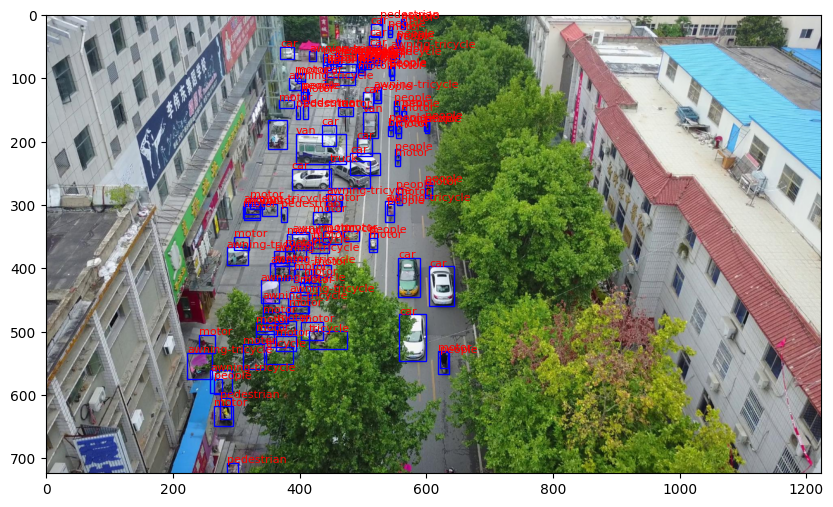

In [71]:
# plotting the image with bboxes.
img, target = dataset_train[0]
plot_img_bbox(img, target)

## **Object Detection Model**

This function returns a Mask R-CNN object detection model with a Fast R-CNN predictor on top. The model is pre-trained on the COCO dataset and takes the number of classes as an input. The output is a model that can be fine-tuned on a custom dataset for object detection tasks.

In [72]:
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [73]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
      
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## **Splitting Dataset**

This code defines and splits a dataset for training and testing using the VisDroneDataset. It also creates dataloaders for both the training and testing sets. The torch.manual_seed(1) sets the seed for random number generation to ensure reproducibility. The indices variable is used to shuffle the dataset for train/test split. The Subset function is used to split the dataset into training and testing sets. The collate_fn parameter is used to merge the individual data samples into batches for efficient processing during training and testing.


In [74]:
# use our dataset and defined transformations
dataset_train = VisDroneDataset(files_dir_train+'/images',files_dir_train+'/annotations', 480, 480, transforms= get_transform(train=True))
dataset_test = VisDroneDataset('/content/images','/content/annotations', 480, 480, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset_train)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset_train)*test_split)
dataset_train = torch.utils.data.Subset(dataset_train, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [75]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 12

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# Define the hyperparameters
lr = 0.005
momentum = 0.9
weight_decay = 0.0005
step_size = 3
gamma = 0.1

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr,
                            momentum, weight_decay)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size,
                                               gamma)

## **Train and Evaluate Model**

This code performs the training and evaluation loop for an object detection model. It uses the train_one_epoch function to train the model for one epoch and stores the loss and accuracy metrics for both training and testing sets in lists. The evaluate function is used to evaluate the model on the testing set after each epoch and store the loss and accuracy metrics. It also implements early stopping by checking if the current test loss is the best so far and if there is no improvement after a certain number of epochs, the training is stopped early. The num_epochs variable sets the number of epochs for which the model will be trained, and patience sets the number of epochs after which training will be stopped if there is no improvement in the testing loss. Finally, the lists of metrics are stored for later analysis and plotting.

In [76]:
import matplotlib.pyplot as plt

# initialize lists to store the metrics
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# training for 2 epochs
num_epochs = 20

# initialize variables for early stopping
best_test_loss = float('inf')
patience = 5
counter = 0

for epoch in range(num_epochs):
    # training for one epoch
    metric_logger = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    train_loss = metric_logger.meters['loss'].avg
    train_accuracy = metric_logger.meters['accuracy'].avg
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # update the learning rate
    lr_scheduler.step()

     # evaluate on the test dataset after each epoch
    coco_evaluator = evaluate(model, data_loader_test, device=device)
    test_loss = coco_evaluator.coco_eval['bbox'].stats[0]
    test_accuracy = coco_evaluator.coco_eval['bbox'].stats[1]
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    # check if the current test loss is the best so far
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        counter = 0
    else:
        counter += 1
    
    # check if we should stop training early
    if counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break


Epoch: [0]  [  0/439]  eta: 0:07:54  lr: 0.000016  loss: 7.1168 (7.1168)  loss_classifier: 2.8043 (2.8043)  loss_box_reg: 0.8410 (0.8410)  loss_mask: 1.6173 (1.6173)  loss_objectness: 1.6281 (1.6281)  loss_rpn_box_reg: 0.2261 (0.2261)  time: 1.0798  data: 0.6108  max mem: 3460
Epoch: [0]  [ 10/439]  eta: 0:02:39  lr: 0.000130  loss: 5.6319 (5.6488)  loss_classifier: 2.7451 (2.6820)  loss_box_reg: 0.6944 (0.7170)  loss_mask: 1.3374 (1.3329)  loss_objectness: 0.2739 (0.5074)  loss_rpn_box_reg: 0.3703 (0.4094)  time: 0.3722  data: 0.0695  max mem: 3460
Epoch: [0]  [ 20/439]  eta: 0:02:24  lr: 0.000244  loss: 4.1572 (4.5087)  loss_classifier: 2.1625 (2.1404)  loss_box_reg: 0.6930 (0.7202)  loss_mask: 0.9180 (0.9025)  loss_objectness: 0.2713 (0.3756)  loss_rpn_box_reg: 0.3550 (0.3700)  time: 0.3087  data: 0.0169  max mem: 3460
Epoch: [0]  [ 30/439]  eta: 0:02:12  lr: 0.000359  loss: 2.4515 (3.8163)  loss_classifier: 1.1023 (1.7839)  loss_box_reg: 0.6905 (0.7034)  loss_mask: 0.1074 (0.6283) 

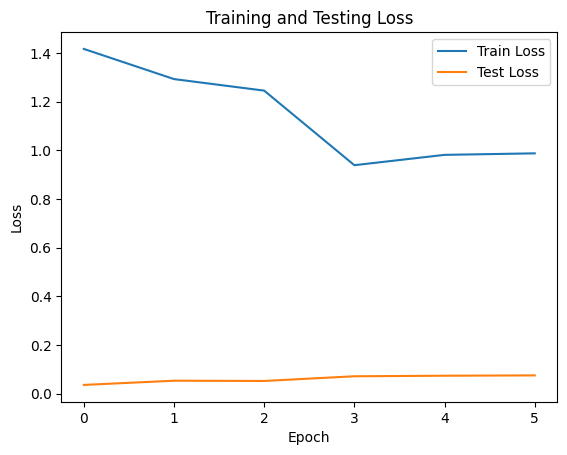

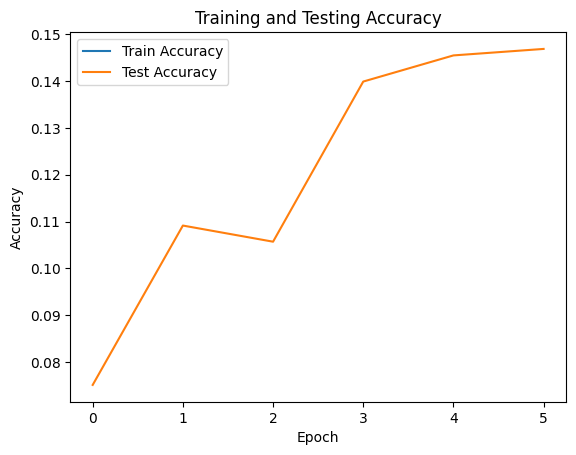

In [77]:
# plot the metrics
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('Training and Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()
plt.title('Training and Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

## **Non-Max Supression (NMS)**

This code defines two utility functions.

The first function apply_nms takes the original prediction and an IOU threshold and applies non-maximum suppression (NMS) on the predicted bounding boxes. It uses the torchvision.ops.nms function to return the indices of the bounding boxes to keep after NMS. It then creates a final prediction dictionary with only the kept bounding boxes, scores, and labels.

The second function torch_to_pil is a helper function that takes a Torch tensor and converts it back to a PIL image. It uses the torchtrans.ToPILImage() function to convert the tensor to a PIL image and then converts it to an RGB image.

In [78]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.1):   
    boxes = torch.Tensor(orig_prediction['boxes'])
    scores = torch.Tensor(orig_prediction['scores'])
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(boxes, scores, iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

In [79]:
import numpy as np
import torch

# Assuming that `img` is a numpy array with image data
img_tensor = torch.from_numpy(img).to(device)

## **Predicted Boxes vs Real Boxes**

This code snippet loads an image img, converts it into a PyTorch tensor, and feeds it into a pre-trained object detection model model to obtain the predicted bounding boxes and class labels. The code then prints the number of predicted boxes and the number of true boxes in the target image to compare them. This is useful for evaluating the performance of the object detection model.

In [80]:
model.eval()
with torch.no_grad():
    img_tensor = torch.from_numpy(img).to(device)
    img_tensor = img_tensor.permute(2, 0, 1)  # Permute the dimensions
    prediction = model([img_tensor])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  100
real #boxes:  128


## **Calculate Accuracy**

This code defines a function calculate_accuracy that takes in the predicted and target bounding boxes with their corresponding labels and calculates the accuracy of the model. It does this by comparing the predicted and ground truth boxes based on Intersection over Union (IOU) and checking if the predicted label matches the ground truth label. The function returns the accuracy, which is the number of correctly matched boxes divided by the total number of boxes. Finally, the function is called with the predicted and target bounding boxes and the calculated accuracy is printed.

In [81]:
def calculate_accuracy(prediction, target, iou_threshold=0.5):

    pred_labels = prediction['labels'].cpu().numpy()
    true_labels = target['labels'].cpu().numpy()

    # Match predicted and ground truth boxes based on IOU
    matched_true_boxes = np.zeros(len(true_labels))
    matched_scores = np.zeros(len(pred_labels))
    for i, pred_box in enumerate(prediction['boxes']):
        for j, true_box in enumerate(target['boxes']):
            iou = calculate_iou(pred_box.cpu().numpy(), true_box.cpu().numpy())
            if iou > iou_threshold and true_labels[j] == pred_labels[i]:
                matched_true_boxes[j] = 1
                matched_scores[i] = prediction['scores'][i]

    # Calculate accuracy as the number of matched boxes divided by the total number of boxes
    accuracy = np.sum(matched_true_boxes) / len(true_labels)
    return accuracy

In [82]:
accuracy = calculate_accuracy(prediction, target, iou_threshold=0.5)
print('Accuracy:', accuracy)

Accuracy: 0.328125


EXPECTED OUTPUT


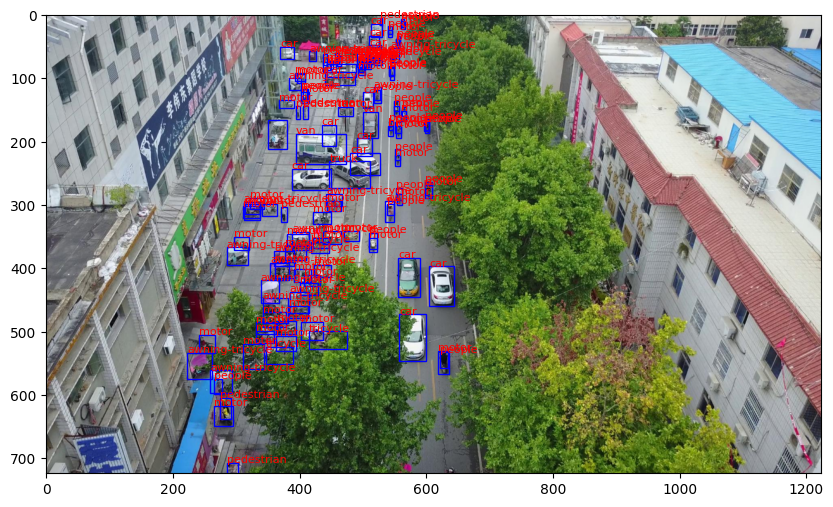

In [83]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img_tensor), target)

MODEL OUTPUT


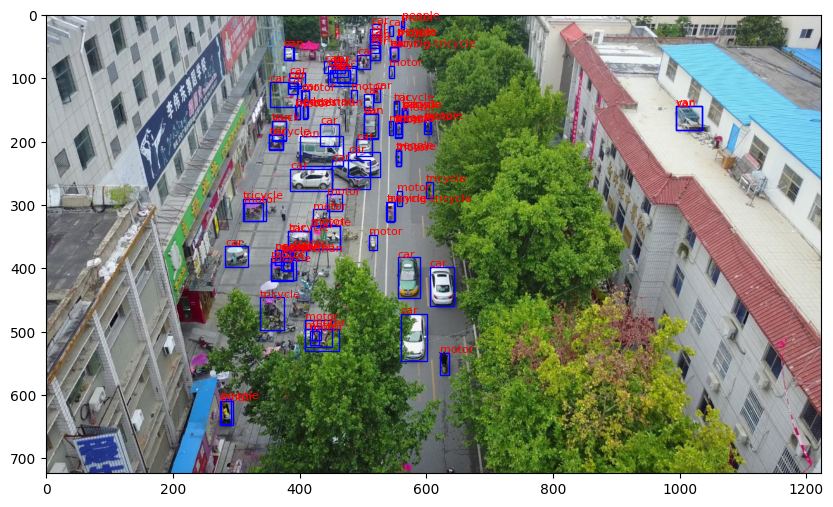

In [84]:
print('MODEL OUTPUT')
prediction_cpu = {k: v.cpu() for k, v in prediction.items()}
plot_img_bbox(torch_to_pil(img_tensor.cpu()), prediction_cpu)

NMS APPLIED MODEL OUTPUT


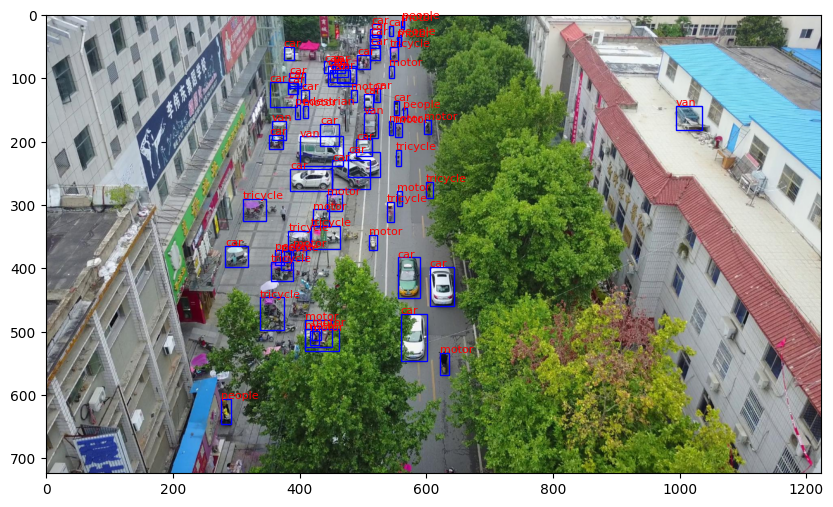

In [85]:
nms_prediction = apply_nms(prediction, iou_thresh=0.5)
nms_prediction_tensors = {k: torch.tensor(v) for k, v in nms_prediction.items()}
nms_prediction_cpu = {k: v.cpu().numpy() for k, v in nms_prediction_tensors.items()}
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img_tensor), nms_prediction_cpu)

## **Final Object Detection**

This code is used to test the object detection model's performance on a single image from the test dataset.

First, it creates an instance of the VisDroneDataset class with the test image directory and annotation directory. It randomly selects an image and its corresponding target from the test dataset.

Next, it puts the object detection model in evaluation mode using model.eval(), which disables dropout and batch normalization layers. Then it uses the torch.no_grad() context manager to disable gradient computation during the forward pass.

The model is then passed the input image img and the predicted output prediction is obtained.

The expected output and the model output are displayed side by side using the plot_img_bbox() function. The plot_img_bbox() function takes an image and a dictionary of bounding boxes, scores, and labels and plots the image with the bounding boxes.

The apply_nms() function is used to apply non-maximum suppression on the predicted bounding boxes to remove redundant detections. The resulting prediction is then displayed alongside the original image.

EXPECTED OUTPUT



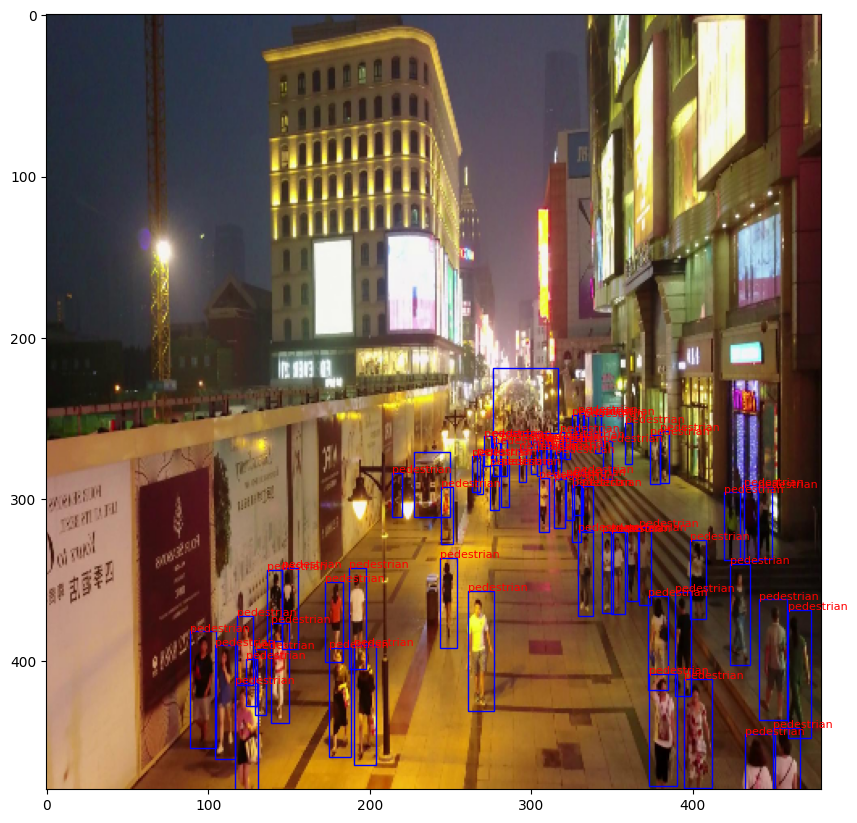

MODEL OUTPUT



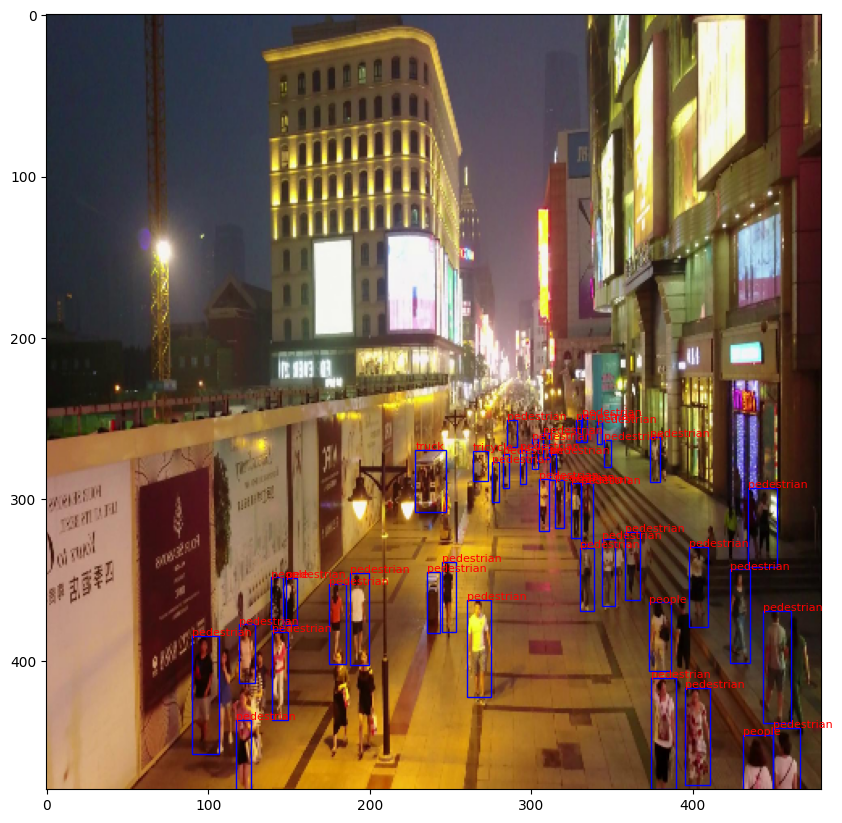

In [87]:
test_dataset = VisDroneDataset('/content/images','/content/annotations', 480, 480, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[random.randint(0, len(dataset_test) - 1)]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)
nms_prediction_cpu = nms_prediction['boxes'].cpu().numpy()  # transfer the boxes tensor to CPU and convert it to a numpy array
nms_prediction['boxes'] = nms_prediction_cpu  # update the dictionary with the new numpy array

plot_img_bbox(torch_to_pil(img), nms_prediction)